In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point
import json
from tqdm.auto import tqdm
pd.set_option('min_rows', 30)
import sys
sys.path.append('..')
from importlib import reload
# import src.utils as utils
# reload(utils)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

## Setup

In [ ]:
%%time
parcels = gpd.read_file('input/lds-nz-primary-parcels-CLIPPED-4326.gpkg')

In [80]:
parcels_sample = parcels.sample(10000)

In [81]:
# keep a centroid and polygon version - change between according to need
parcels_sample['geometry_centroid'] = parcels_sample.geometry.centroid
parcels_sample['geometry_polygon'] = parcels_sample.geometry

<ipython-input-81-9e0513578c82>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parcels_sample['geometry_centroid'] = parcels_sample.geometry.centroid


## 3. Local Area (LA) Information (information on the LA that the consent is located in): 

#### a. Name (just the string is fine; I did not generate numeric codes for the local areas generated) **Local_Area_name**

## 4. 2018 Statistical Area 2 Information (information on the 2018SA2 that the consent is located in)

#### a. Name (string) **SA22018_name**
#### b. Numeric code **SA22018_code**

In [11]:
sa2 = gpd.read_file('NZ-SA/statistical-area-2-2020-generalised.gdb').to_crs(4326)
sa2.sample(3)

In [82]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid']
parcels_sample = gpd.sjoin(parcels_sample, sa2[['SA22020_V1_00_NAME', 'SA22020_V1_00', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'SA22020_V1_00_NAME': 'SA22018_name', 'SA22020_V1_00': 'SA22018_code'})

CPU times: user 8.29 s, sys: 3.88 ms, total: 8.29 s
Wall time: 8.29 s


## 5. Area Unit Information (information on the 2013AU  that the consent is located in):

#### a. Name (string) **AU2013_name**
#### b. Numeric code **AU2013_code**

In [101]:
au2013 = gpd.read_file('input/area-unit-2013.gdb.zip').to_crs(4326)
au2013.sample(3)

,AU2013_V1_00,AU2013_V1_00_NAME,AREA_SQ_KM,LAND_AREA_SQ_KM,Shape_Length,geometry
1481,573903,Newlands North,0.804087,0.804087,5958.640337,"MULTIPOLYGON (((174.82896 -41.21949, 174.83011..."
958,525202,Kawakawa-Orere,105.216001,105.216001,57437.556145,"MULTIPOLYGON (((175.14259 -36.93214, 175.14265..."
608,597102,Inland Water-Lake Ellesmere South,63.304671,0.000000,75233.330853,"MULTIPOLYGON (((172.57398 -43.76779, 172.57401..."


In [103]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid']
parcels_sample = gpd.sjoin(parcels_sample, au2013[['AU2013_V1_00_NAME', 'AU2013_V1_00', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'AU2013_V1_00_NAME': 'AU2013_name', 'AU2013_V1_00': 'AU2013_code'})

CPU times: user 6.96 s, sys: 0 ns, total: 6.96 s
Wall time: 6.96 s


## 6. 2018 Meshblock Information (information on the 2018MB  that the consent is located in):

#### a. Code **MB2018_code**

In [100]:
mb2018 = gpd.read_file('input/meshblock-2018-clipped-generalised.gdb.zip').to_crs(4326)
mb2018.sample(3)

,MB2018_V1_00,LANDWATER,LANDWATER_NAME,LAND_AREA_SQ_KM,AREA_SQ_KM,SHAPE_Length,geometry
52865,4011926,12,Mainland,0.173710,0.173710,2129.422679,"MULTIPOLYGON (((174.91945 -36.94519, 174.92053..."
23832,1429800,12,Mainland,0.021918,0.021918,731.394363,"MULTIPOLYGON (((176.91682 -39.49291, 176.91702..."
15554,0759520,12,Mainland,0.020695,0.020695,928.355735,"MULTIPOLYGON (((174.91840 -37.01411, 174.91871..."


In [97]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid']
parcels_sample = gpd.sjoin(parcels_sample, mb2018[['MB2018_V1_00', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'MB2018_V1_00': 'MB2018_code'})

CPU times: user 11.3 s, sys: 8.2 ms, total: 11.3 s
Wall time: 11.3 s


## 7. 2013 Meshblock Information (information on the 2013MB  that the consent is located in):

#### a. Code **MB2013_code**

In [84]:
mb2013 = gpd.read_file('input/meshblock-2013.gdb.zip').to_crs(4326)
mb2013.sample(3)

In [87]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid']
parcels_sample = gpd.sjoin(parcels_sample, mb2013[['MeshblockNumber', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'MeshblockNumber': 'MB2013_code'})

CPU times: user 11.4 s, sys: 7.05 ms, total: 11.4 s
Wall time: 11.4 s


## 8. Additional distance information from consent location  
For these distance calculations, use EPSG 2193 (less distortion).

In [116]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid']
parcels_sample = parcels_sample.to_crs(2193)
parcels_sample.sample(3)

,id,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,titles,survey_area,calc_area,geometry,geometry_centroid,geometry_polygon,SA22018_name,SA22018_code,MB2013_code,MB2018_code,AU2013_name,AU2013_code
102782,4896031,Lot 1 DP 61837,DP 61837,DCDB,Primary,None,North Auckland,NA17C/935,685.0,685.0,POINT (1773608.374 5914596.096),POINT (174.94849 -36.89867),"MULTIPOLYGON (((174.94827 -36.89874, 174.94841...",Cockle Bay,153400,0655102,0655102,Cockle Bay,521502
119786,4931702,Lot 4 DP 166054,DP 166054,DCDB,Primary,None,North Auckland,NA100D/34,52130.0,50575.0,POINT (1783027.533 5889659.615),POINT (175.06020 -37.12153),"MULTIPOLYGON (((175.06295 -37.12105, 175.06293...",Ararimu,166400,0815302,0815302,Hunua,521132
362342,7415715,Lot 23 DP 455616,"DP 455616, DP 462513",Fee Simple Title,Primary,None,North Auckland,586776,103.0,103.0,POINT (1763989.858 5916157.717),POINT (174.84025 -36.88632),"MULTIPOLYGON (((174.84016 -36.88629, 174.84020...",Stonefields West,144900,0465305,4000293,Stonefields,517202


- a. Minimum Haversine distance to coastline **Hdist_coast**  
There are a few different datasets that could be used for this:  
    - NZ Coastlines (Topo 1:50k) https://data.linz.govt.nz/layer/50258-nz-coastlines-topo-150k/
    - NZ Coastline - mean high water https://data.linz.govt.nz/layer/105085-nz-coastline-mean-high-water/
    - NZ Coastlines and Islands Polygons (Topo 1:50k) https://data.linz.govt.nz/layer/51153-nz-coastlines-and-islands-polygons-topo-150k/  

The first doesn't have islands (e.g. Waiheke).  
The second is probably most appropriate.

CPU times: user 10.5 s, sys: 89.7 ms, total: 10.6 s
Wall time: 10.6 s


<AxesSubplot:>

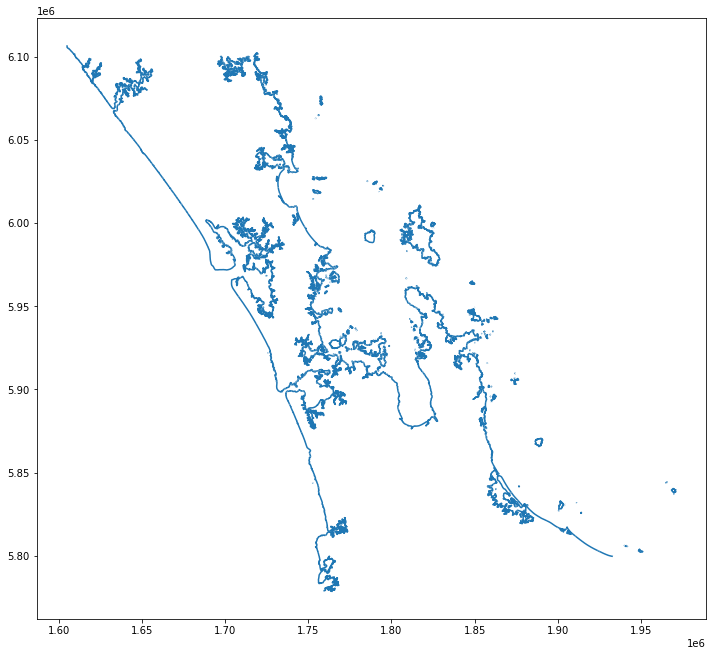

In [167]:
%%time
bounds2193 = {'x1': 1.5e6, 'x2':2e6, 'y1':5.8e6, 'y2':6.1e6}
coastline = gpd.read_file('input/lds-nz-coastline-mean-high-water-FGDB.zip!nz-coastline-mean-high-water.gdb').to_crs(2193)
coastline = coastline.cx[bounds2193['x1']:bounds2193['x2'], bounds2193['y1']:bounds2193['y2']]
coastline_dissolved = coastline.dissolve()
coastline_dissolved.plot()

In [169]:
%%time
parcels_sample['Hdist_coast'] = parcels_sample.apply(lambda x: x.geometry.distance(coastline_dissolved.geometry[0]), axis=1)

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 14.3 s


<AxesSubplot:>

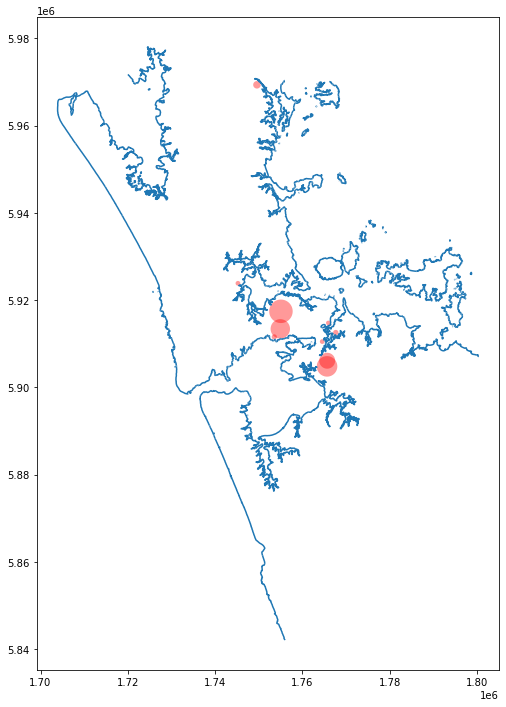

In [198]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_sample.sample(10)
subsample['coast_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_coast), axis=1)
subsample['geometry'] = subsample['coast_buffer']
ax = subsample.plot(color='red', alpha=0.4)
coastline.cx[1.7e6:1.8e6, 5.85e6:5.97e6].plot(ax=ax)

- b. Minimum Haversinedistance to Open Space(set of AUP Zones) **Hdist_open**

- b. Minimum Haversinedistance to Open Space(set of AUP Zones) **Hdist_open**
- c. Minimum Haversine distance to motorway **Hdist_motorway**
- d. Minimum Haversine distanceto main arterial road **Hdist_main_road**
- e. Minimum Haversine distance to rail line **Hdist_rail**
- f. Haversine distance to downtown (use Skytower coordinates) **Hdist_skytower**

In [ ]:
from shapely.geometry import Point
random_points = 

In [107]:
import geopandas as gpd
from shapely.geometry import Point
N = Point(-177.86957899263666, -29.231440487079798)
S = Point(169.1272753839956, -52.61676648744082)
series = gpd.GeoSeries([N, S], crs="EPSG:4326").to_crs(epsg=3854)
print(series[0].distance(series[1]) / 1000)

2916.5841962228014
